In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import scipy.optimize as optimize


from bo_functions import ExactGPModel
from bo_functions import test_train_split
from bo_functions import bo_iter
from bo_functions import bo_iter_w_restarts

In [2]:
#Set Parameters
Theta_True = np.array([1,-1])
q = 2
m = 1
BO_iters = 15
restarts = 10
train_iter = 300

emulator = False
verbose = False

shuffle_seed = 6
t=4
# verbose= False

train_iter = 300
explore_bias = torch.tensor([0,0.1,0.5])

#Pull Experimental data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(0.5,1.5,p) #1x10
Theta2 =  np.linspace(-1.5,-0.5,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

# shape = theta_mesh.shape
# for i in range(len(shape)):
#     print(theta_mesh.shape[i])

Explore Bias: tensor(0.)
Restart Number:  1


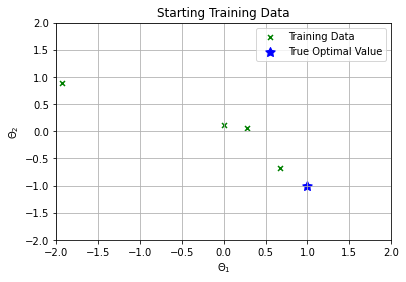

UnboundLocalError: local variable 'q' referenced before assignment

In [3]:
save_fig=False
obj = "LN_obj"

all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, obj,
                       restarts, verbose,save_fig,emulator, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

Explore Bias: tensor(0.)
Restart Number:  1


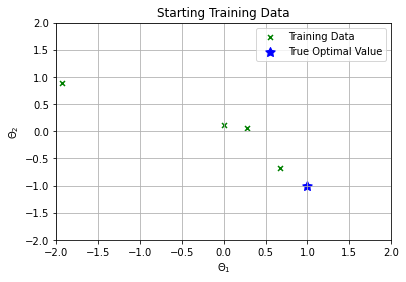

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Magnitude of SSE given Theta_Opt =  [ 0.95495328 -0.90283498] is 3.5875e-01
Restart Number:  2


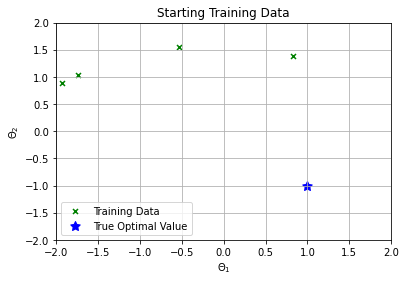

Magnitude of SSE given Theta_Opt =  [ 0.70664428 -0.89677528] is 1.2120e+00
Restart Number:  3


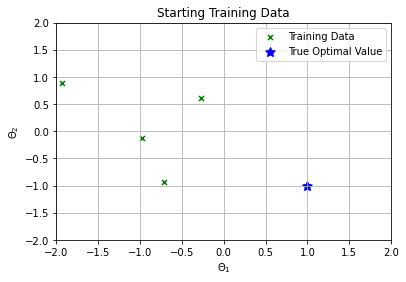

Magnitude of SSE given Theta_Opt =  [ 1.05278793 -1.08916719] is 2.8500e-01
Restart Number:  4


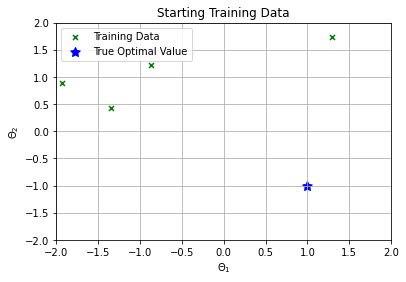

Magnitude of SSE given Theta_Opt =  [ 1.12962144 -0.99445218] is 1.8659e-01
Restart Number:  5


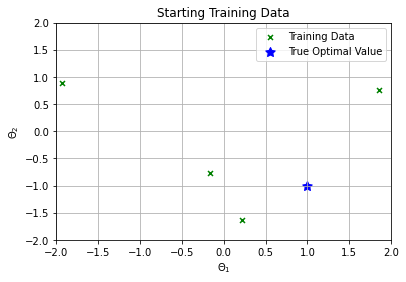

Magnitude of SSE given Theta_Opt =  [ 1.30405949 -0.93015206] is 1.1434e+00
Restart Number:  6


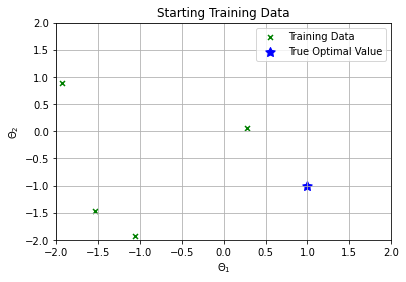

Magnitude of SSE given Theta_Opt =  [ 0.88547309 -0.93809415] is 2.6261e-01
Restart Number:  7


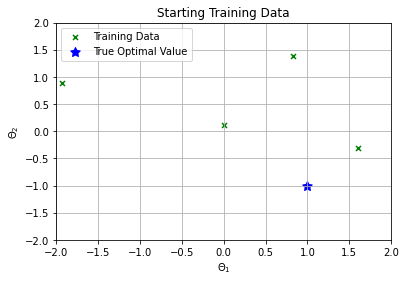

Magnitude of SSE given Theta_Opt =  [ 0.7000546  -1.11355845] is 1.2772e+00
Restart Number:  8


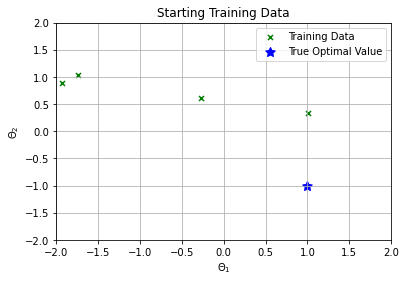

Magnitude of SSE given Theta_Opt =  [ 1.0204901  -0.97711279] is 3.0427e-02
Restart Number:  9


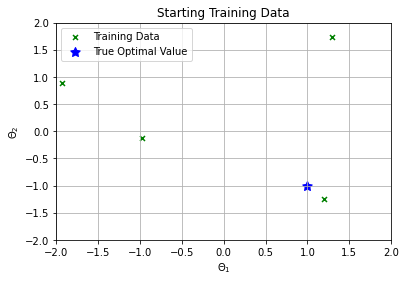

Magnitude of SSE given Theta_Opt =  [ 1.07283746 -0.77477018] is 1.8385e+00
Restart Number:  10


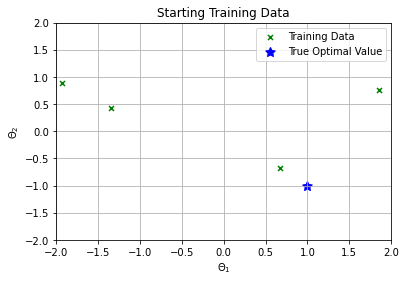

Magnitude of SSE given Theta_Opt =  [ 1.13283855 -0.94877121] is 2.9398e-01


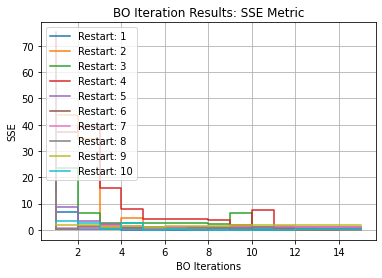

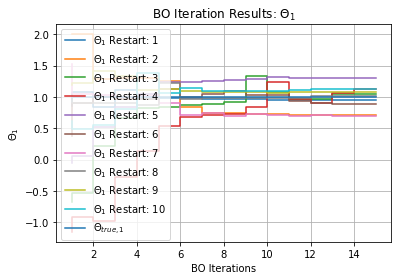

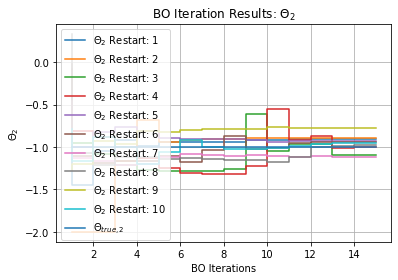

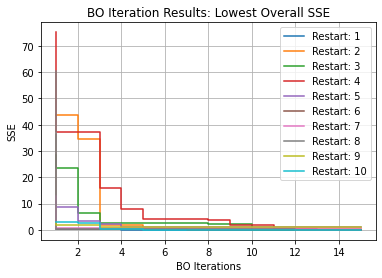

The GP predicts that the lowest SSE of 8.240e-03 occurs at θ = [[ 1.01775757 -0.99463644]] during restart 8
Explore Bias: tensor(0.1000)
Restart Number:  1


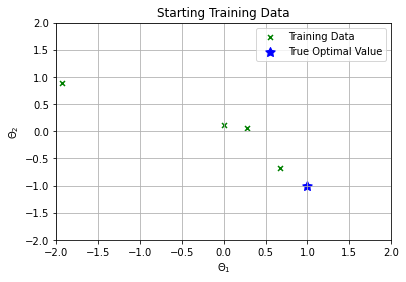

Magnitude of SSE given Theta_Opt =  [ 0.95582282 -0.8915179 ] is 4.3978e-01
Restart Number:  2


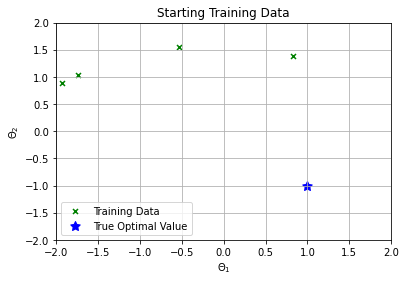

Magnitude of SSE given Theta_Opt =  [ 0.71491227 -0.87760047] is 1.3166e+00
Restart Number:  3


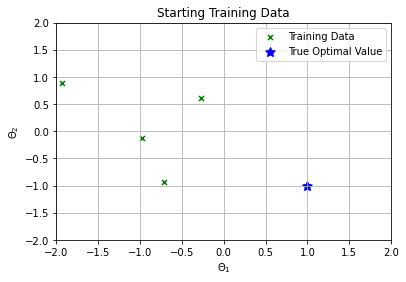

Magnitude of SSE given Theta_Opt =  [ 1.06726032 -0.93232719] is 2.2514e-01
Restart Number:  4


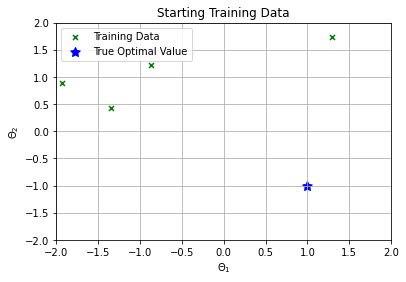

Magnitude of SSE given Theta_Opt =  [ 1.18649358 -1.00486499] is 3.7056e-01
Restart Number:  5


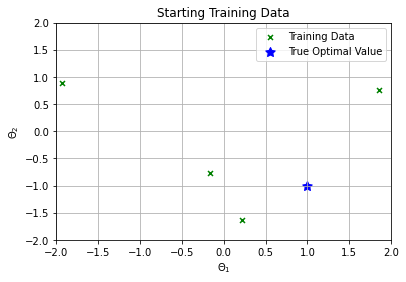

Magnitude of SSE given Theta_Opt =  [ 1.28198825 -0.9101107 ] is 1.1248e+00
Restart Number:  6


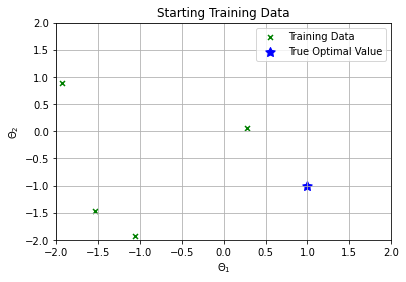

Magnitude of SSE given Theta_Opt =  [ 0.91104328 -0.87690844] is 6.1239e-01
Restart Number:  7


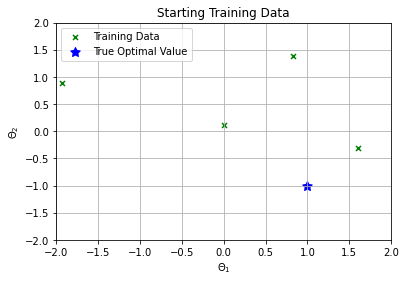

Magnitude of SSE given Theta_Opt =  [ 1.04126581 -0.99882412] is 2.3044e-02
Restart Number:  8


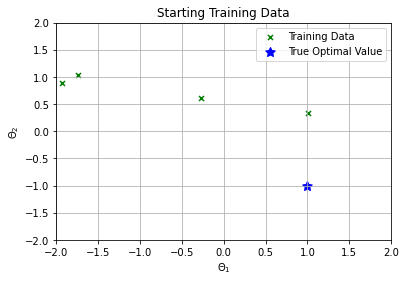

Magnitude of SSE given Theta_Opt =  [ 0.92062701 -0.91722442] is 3.0605e-01
Restart Number:  9


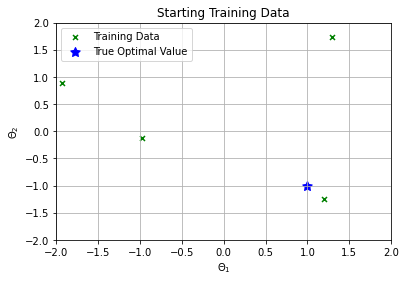

Magnitude of SSE given Theta_Opt =  [ 1.20359503 -0.78715145] is 2.0283e+00
Restart Number:  10


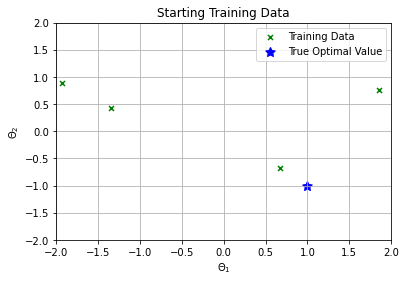

Magnitude of SSE given Theta_Opt =  [ 1.16772105 -0.91689938] is 5.5581e-01


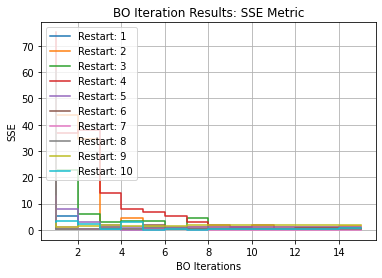

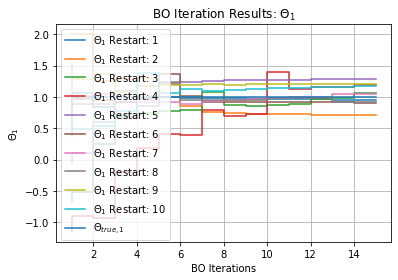

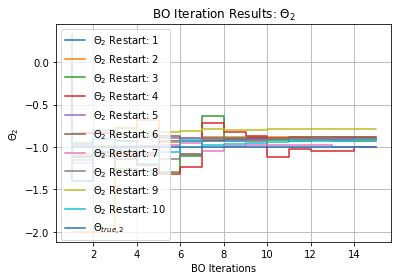

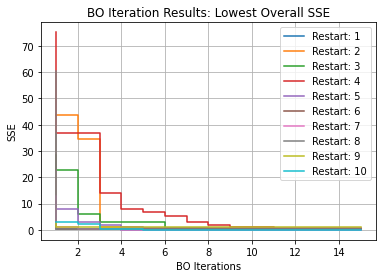

The GP predicts that the lowest SSE of 1.172e-02 occurs at θ = [[ 0.98600932 -0.98531881]] during restart 1
Explore Bias: tensor(0.5000)
Restart Number:  1


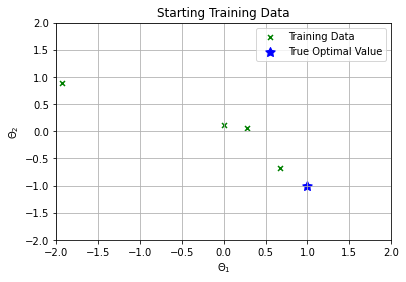

Magnitude of SSE given Theta_Opt =  [ 0.9727089  -0.96019737] is 6.7863e-02
Restart Number:  2


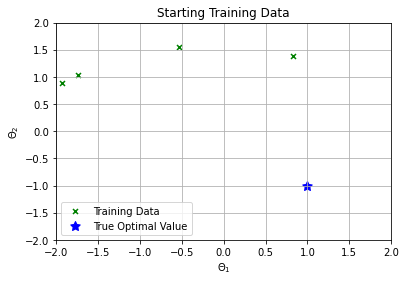

Magnitude of SSE given Theta_Opt =  [ 0.90556348 -0.9992859 ] is 7.8838e-02
Restart Number:  3


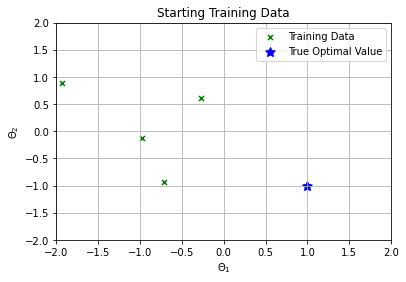

Magnitude of SSE given Theta_Opt =  [ 1.12902476 -1.00034704] is 1.8259e-01
Restart Number:  4


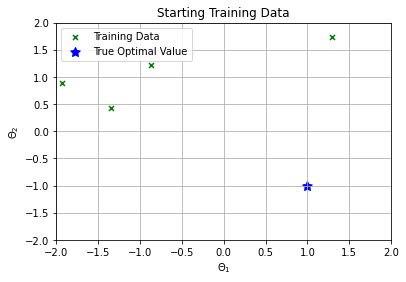

Magnitude of SSE given Theta_Opt =  [ 0.89565969 -0.97466853] is 1.2474e-01
Restart Number:  5


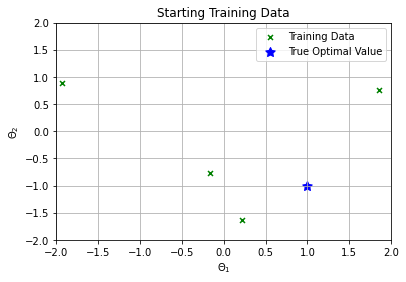

Magnitude of SSE given Theta_Opt =  [ 0.89412887 -0.97631086] is 1.2466e-01
Restart Number:  6


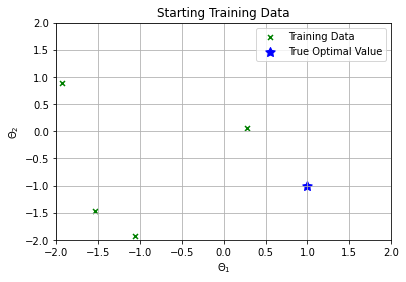

Magnitude of SSE given Theta_Opt =  [ 0.87875074 -0.87701899] is 6.7546e-01
Restart Number:  7


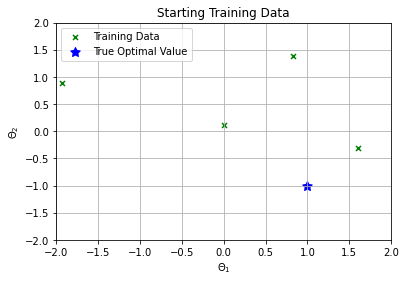

Magnitude of SSE given Theta_Opt =  [ 1.14970039 -0.95937204] is 3.0812e-01
Restart Number:  8


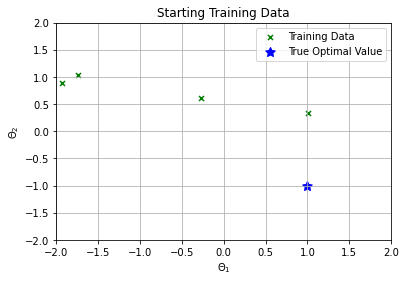

Magnitude of SSE given Theta_Opt =  [ 0.99228138 -0.92786879] is 1.9373e-01
Restart Number:  9


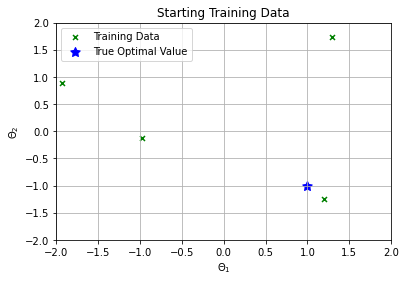

Magnitude of SSE given Theta_Opt =  [ 0.90306869 -0.95969299] is 1.4753e-01
Restart Number:  10


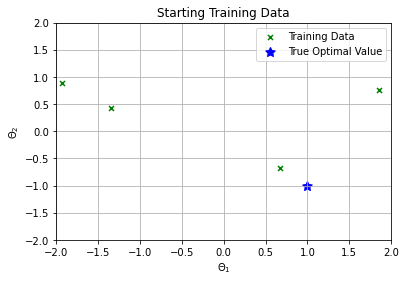

Magnitude of SSE given Theta_Opt =  [ 1.18640067 -0.92839302] is 5.6112e-01


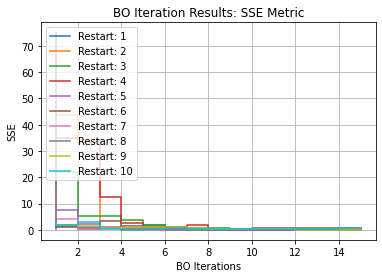

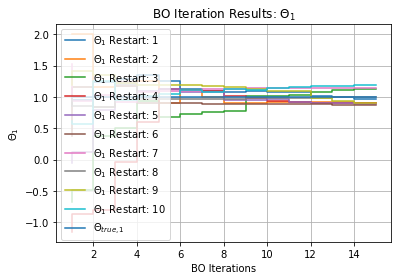

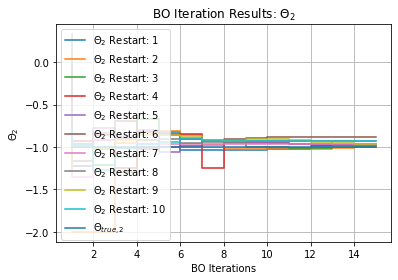

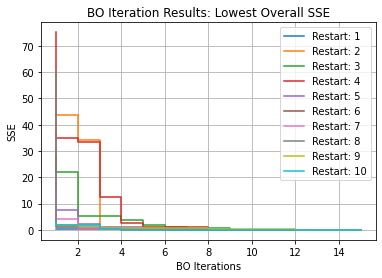

The GP predicts that the lowest SSE of 2.859e-03 occurs at θ = [[ 1.00952417 -0.99980143]] during restart 3


In [3]:
save_fig=False
obj = "LN_obj"

all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,p,q,m,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, obj,
                       restarts, verbose,save_fig,emulator, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

Explore Bias: tensor(0.)
Restart Number:  1


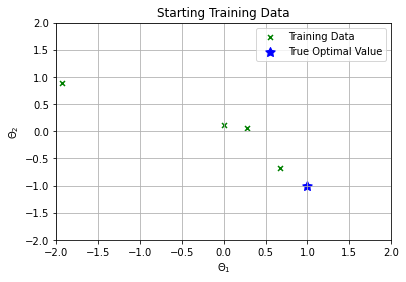

Magnitude of SSE given Theta_Opt =  [ 0.99000117 -1.19877046] is 1.2987e+00
Restart Number:  2


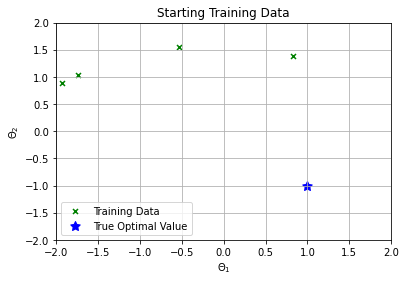

Magnitude of SSE given Theta_Opt =  [ 2.         -0.77108422] is 1.1954e+01
Restart Number:  3


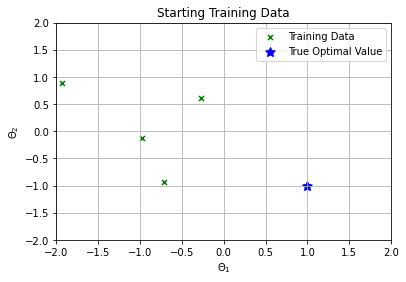

Magnitude of SSE given Theta_Opt =  [ 0.25954902 -1.26577643] is 7.7362e+00
Restart Number:  4


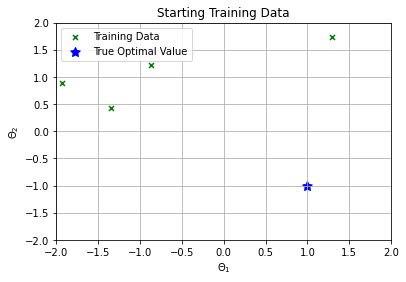

Magnitude of SSE given Theta_Opt =  [ 0.08190909 -1.02430048] is 8.3345e+00
Restart Number:  5


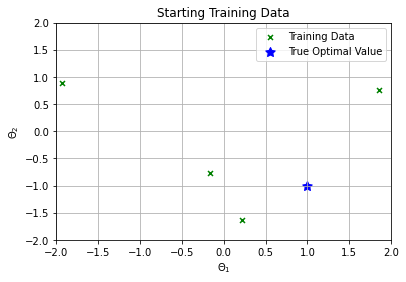

Magnitude of SSE given Theta_Opt =  [-0.16571056 -1.17722092] is 1.4478e+01
Restart Number:  6


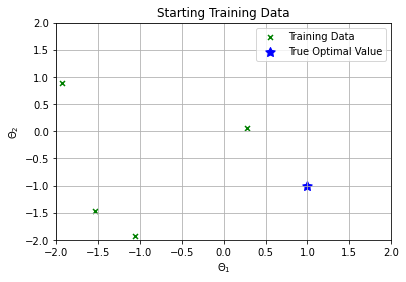

Magnitude of SSE given Theta_Opt =  [ 0.99432673 -0.95444583] is 8.1320e-02
Restart Number:  7


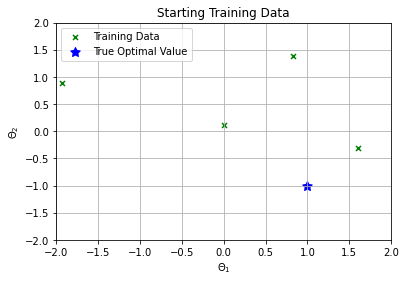

Magnitude of SSE given Theta_Opt =  [ 0.65947732 -1.17440166] is 2.1141e+00
Restart Number:  8


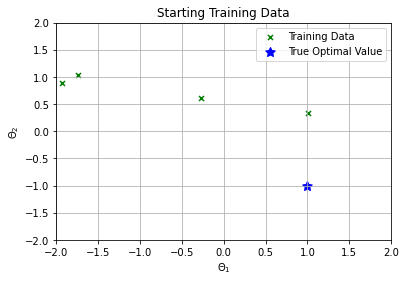

Magnitude of SSE given Theta_Opt =  [ 0.68623782 -1.1050682 ] is 1.2992e+00
Restart Number:  9


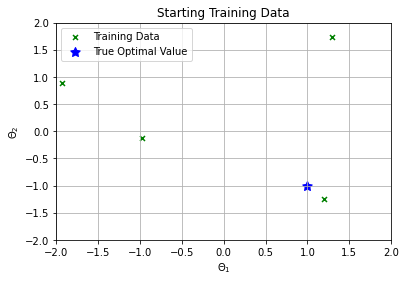

Magnitude of SSE given Theta_Opt =  [ 0.63456804 -1.03085898] is 1.3178e+00
Restart Number:  10


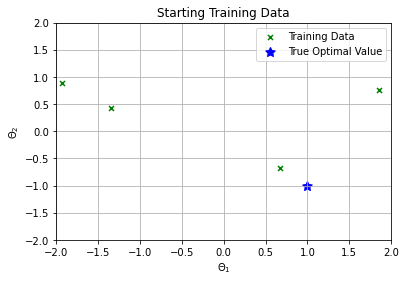

Magnitude of SSE given Theta_Opt =  [ 0.39583094 -0.99681591] is 3.5798e+00


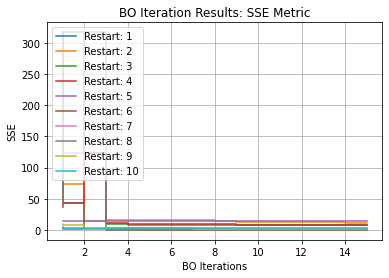

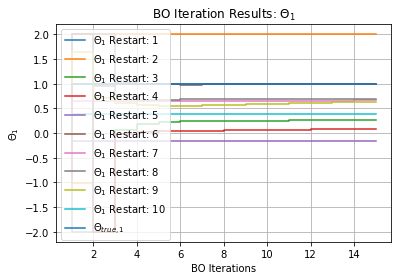

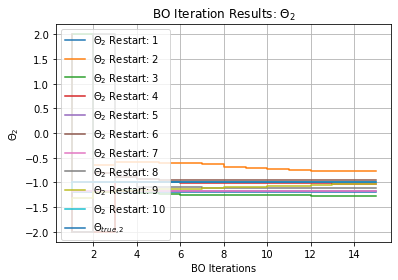

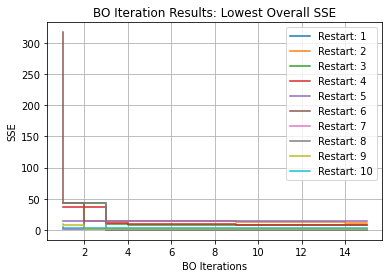

The GP predicts that the lowest SSE of 8.132e-02 occurs at θ = [[ 0.99432673 -0.95444583]] during restart 6
Explore Bias: tensor(0.1000)
Restart Number:  1


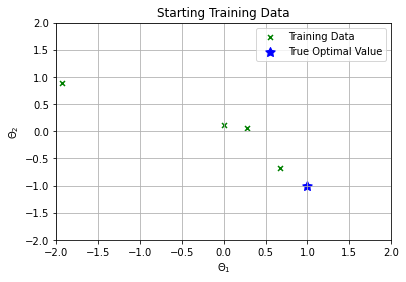

Magnitude of SSE given Theta_Opt =  [ 0.99000426 -1.19874756] is 1.2984e+00
Restart Number:  2


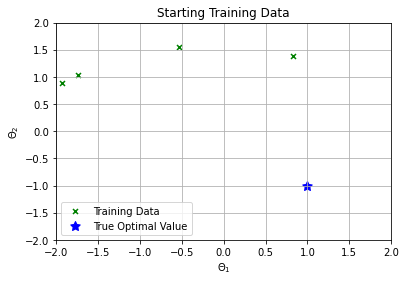

Magnitude of SSE given Theta_Opt =  [ 2.         -0.77109441] is 1.1954e+01
Restart Number:  3


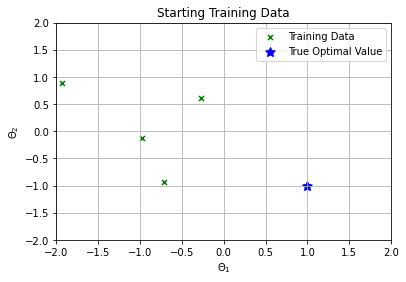

Magnitude of SSE given Theta_Opt =  [ 0.25693406 -1.23326111] is 7.2303e+00
Restart Number:  4


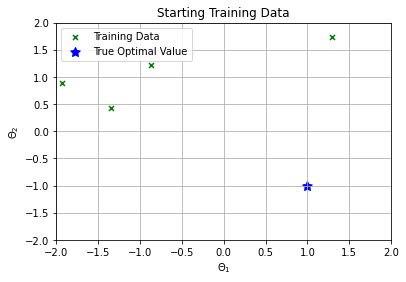

Magnitude of SSE given Theta_Opt =  [ 0.083984   -1.02592906] is 8.2991e+00
Restart Number:  5


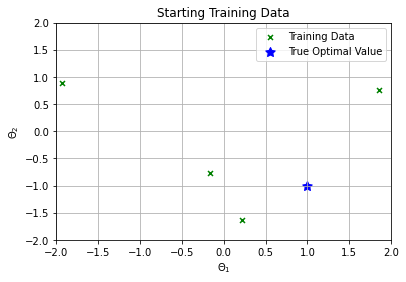

Magnitude of SSE given Theta_Opt =  [-0.16401645 -1.17589684] is 1.4423e+01
Restart Number:  6


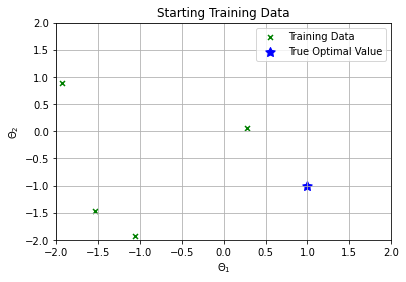

Magnitude of SSE given Theta_Opt =  [ 0.99446787 -0.95439743] is 8.1483e-02
Restart Number:  7


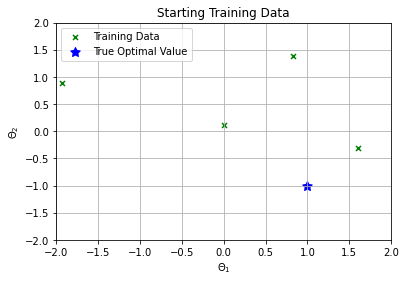

Magnitude of SSE given Theta_Opt =  [ 0.66044865 -1.1745062 ] is 2.1088e+00
Restart Number:  8


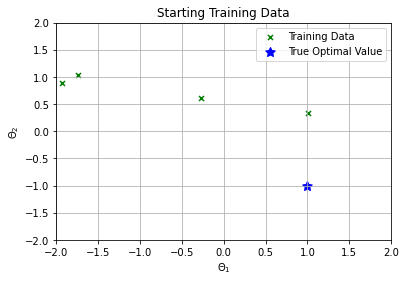

Magnitude of SSE given Theta_Opt =  [ 0.68838462 -1.10843691] is 1.3097e+00
Restart Number:  9


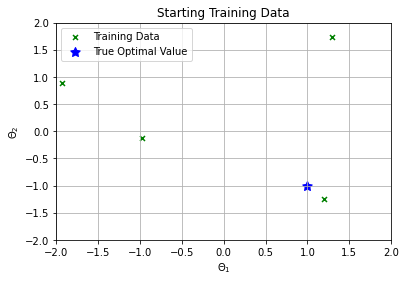

Magnitude of SSE given Theta_Opt =  [ 0.64102544 -1.02285092] is 1.2590e+00
Restart Number:  10


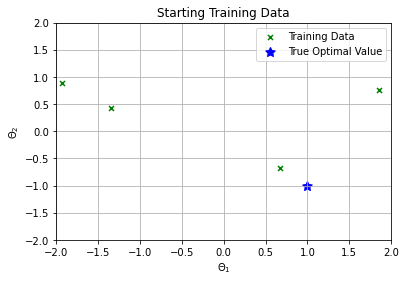

Magnitude of SSE given Theta_Opt =  [ 0.39585279 -0.99681615] is 3.5795e+00


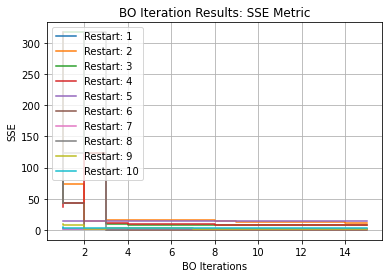

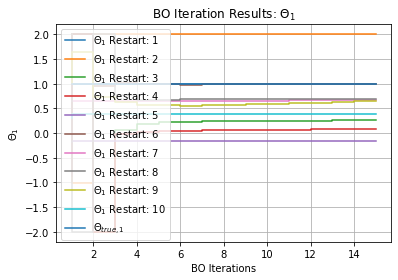

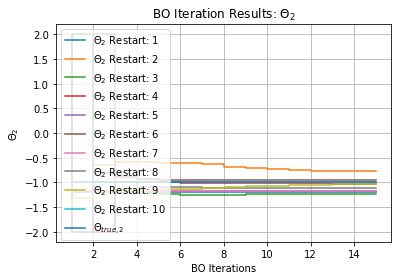

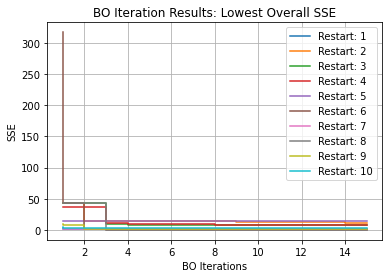

The GP predicts that the lowest SSE of 8.148e-02 occurs at θ = [[ 0.99446787 -0.95439743]] during restart 6
Explore Bias: tensor(0.5000)
Restart Number:  1


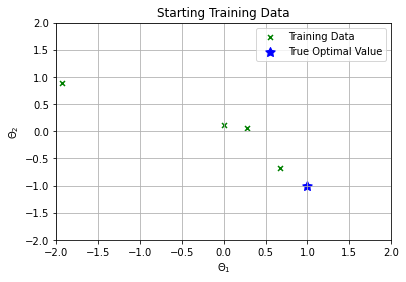

Magnitude of SSE given Theta_Opt =  [ 0.9900078  -1.19864681] is 1.2971e+00
Restart Number:  2


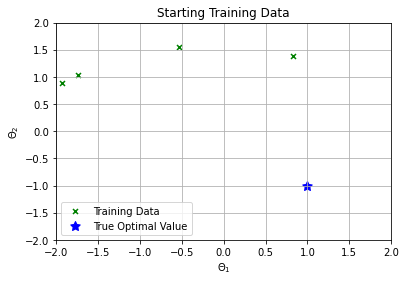

Magnitude of SSE given Theta_Opt =  [ 2.         -0.76854514] is 1.1994e+01
Restart Number:  3


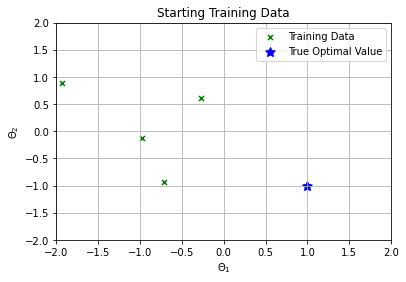

Magnitude of SSE given Theta_Opt =  [ 0.36084245 -1.21831496] is 5.5804e+00
Restart Number:  4


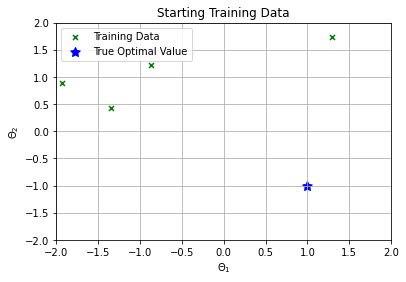

Magnitude of SSE given Theta_Opt =  [ 0.09872872 -1.01204448] is 8.0181e+00
Restart Number:  5


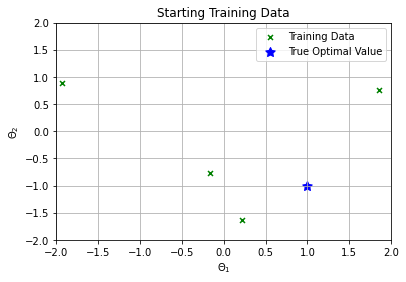

Magnitude of SSE given Theta_Opt =  [ 0.38293111 -0.99220063] is 3.7386e+00
Restart Number:  6


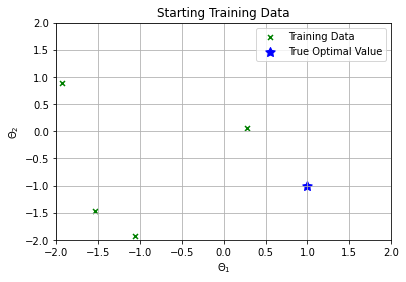

Magnitude of SSE given Theta_Opt =  [ 0.98690632 -0.95842266] is 6.9141e-02
Restart Number:  7


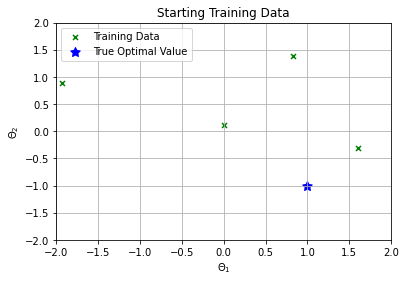

Magnitude of SSE given Theta_Opt =  [ 0.99806229 -1.2077991 ] is 1.4215e+00
Restart Number:  8


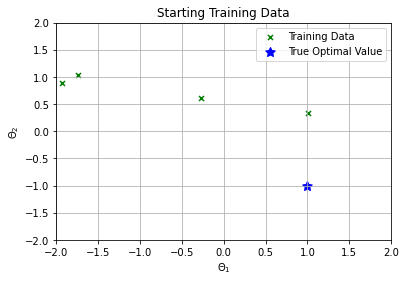

Magnitude of SSE given Theta_Opt =  [ 0.69157657 -1.11224901] is 1.3180e+00
Restart Number:  9


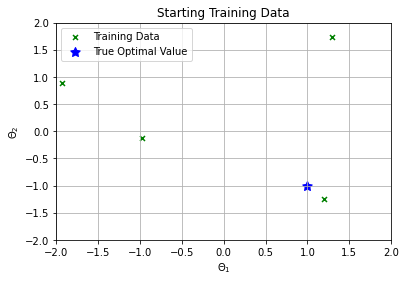

Magnitude of SSE given Theta_Opt =  [ 0.56308846 -1.08146247] is 2.0646e+00
Restart Number:  10


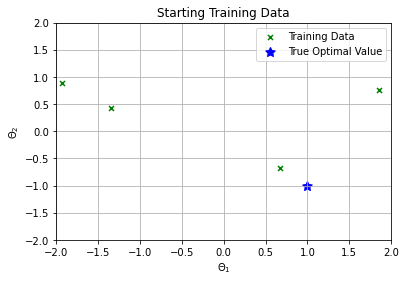

Magnitude of SSE given Theta_Opt =  [ 0.39596566 -0.99682512] is 3.5782e+00


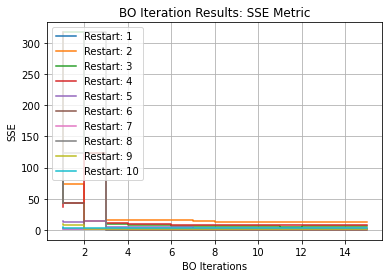

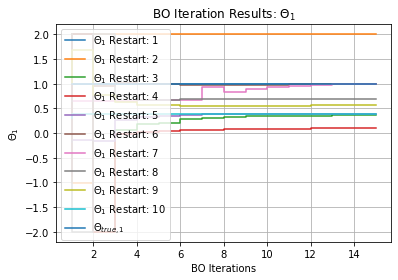

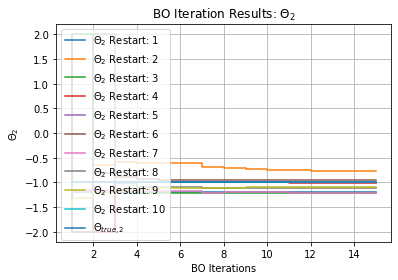

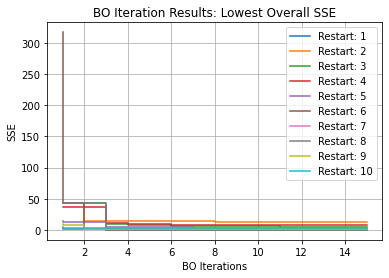

The GP predicts that the lowest SSE of 6.914e-02 occurs at θ = [[ 0.98690632 -0.95842266]] during restart 6


In [4]:
save_fig=False
obj = "obj"

all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,p,q,m,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, obj,
                       restarts, verbose,save_fig,emulator, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

Explore Bias: tensor(0.)
Magnitude of SSE given Theta_Opt =  [ 1.00888611 -0.90362685] is 3.4031e-01


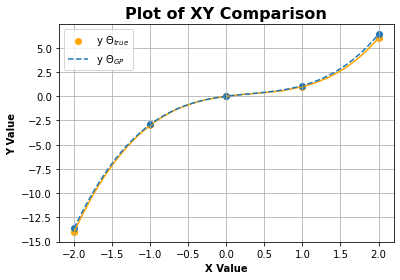

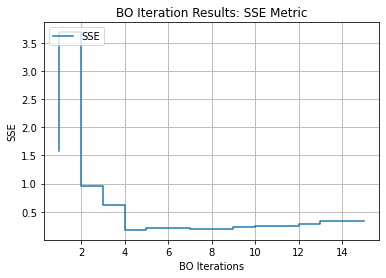

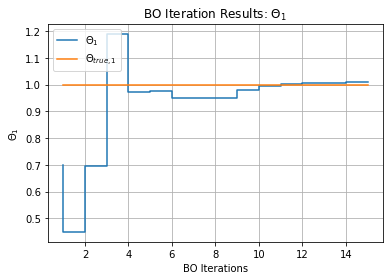

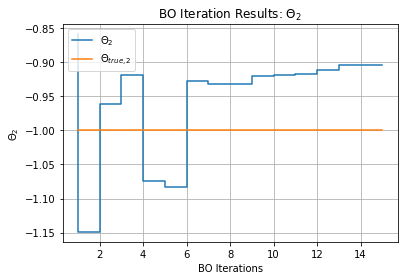

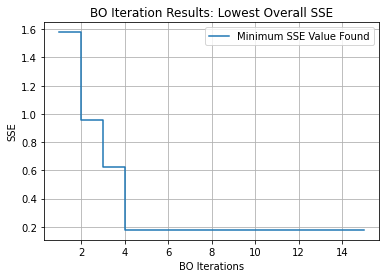

Explore Bias: tensor(0.1000)
Magnitude of SSE given Theta_Opt =  [ 0.99155852 -1.14385444] is 6.7137e-01


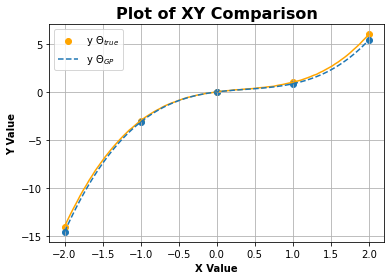

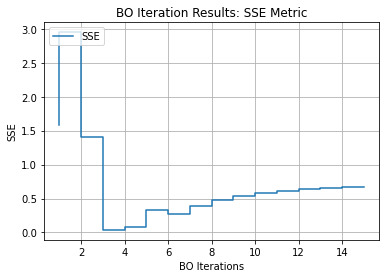

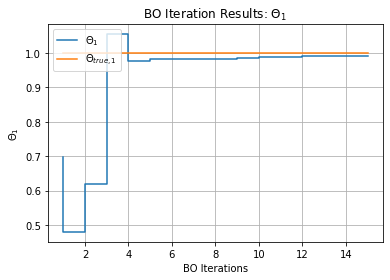

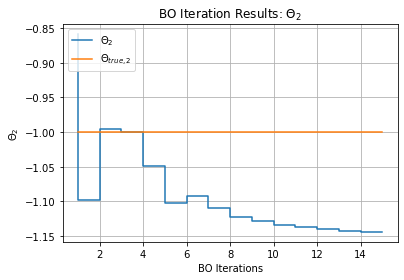

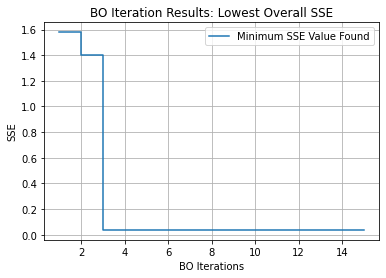

Explore Bias: tensor(0.5000)
Magnitude of SSE given Theta_Opt =  [ 0.98235165 -1.15551238] is 7.8868e-01


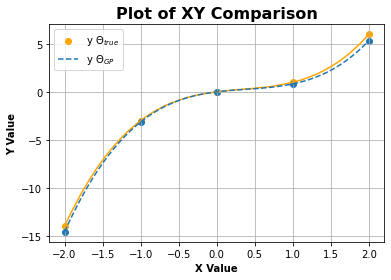

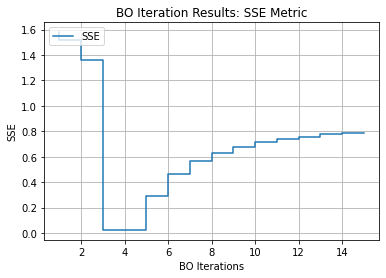

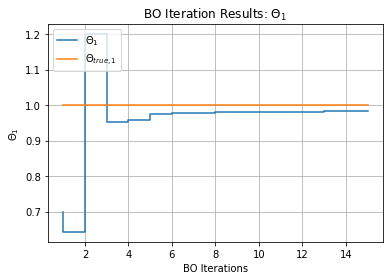

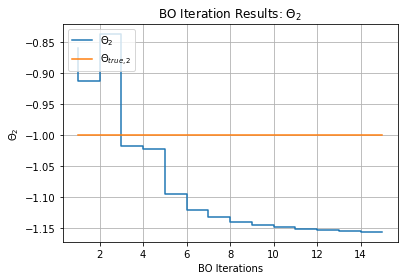

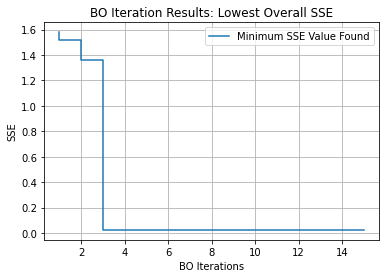

In [5]:
##Objective function = ln(SSE)
##USING SCIPY METHOD
##Uses 4 LHS points

save_fig=False
obj = "LN_obj"
restarts = 0

#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_ln_sse = train_data[:,-1]
t = 4 #Just use last 4 points
train_T = train_T[0:t]
train_ln_sse = train_ln_sse[0:t]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_ln_sse, likelihood)


for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_ln_sse,p,q,m,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, 
                          Yexp, obj, restarts, verbose = verbose,save_fig=save_fig,emulator = emulator)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

Explore Bias: tensor(0.)
Magnitude of SSE given Theta_Opt =  [ 1.05243868 -1.14504045] is 7.1682e-01


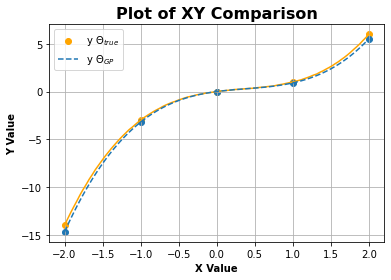

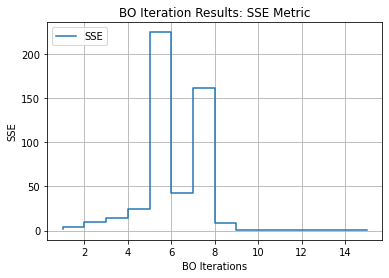

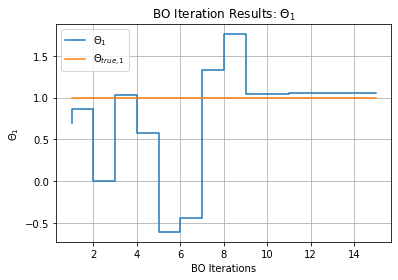

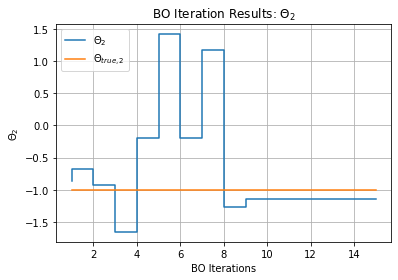

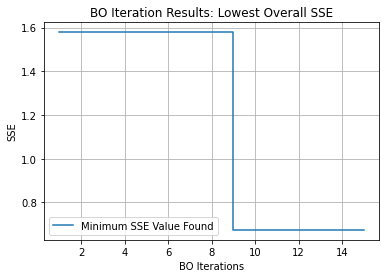

Explore Bias: tensor(0.1000)
Magnitude of SSE given Theta_Opt =  [ 1.26441926 -1.13657004] is 1.3347e+00


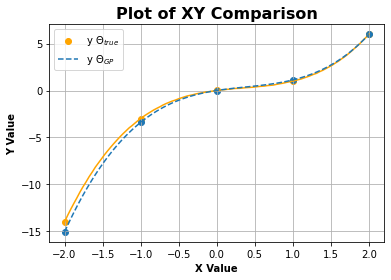

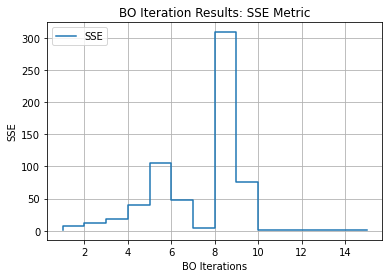

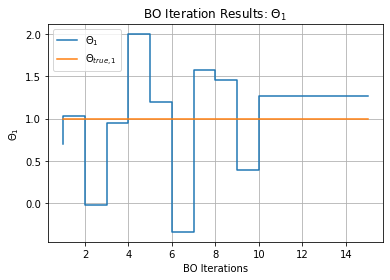

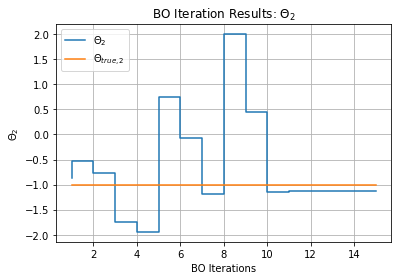

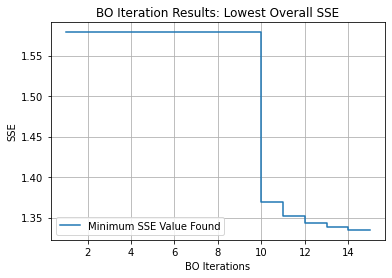

Explore Bias: tensor(0.5000)
Magnitude of SSE given Theta_Opt =  [ 1.348375   -1.12650362] is 1.7714e+00


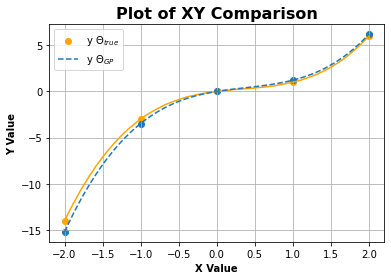

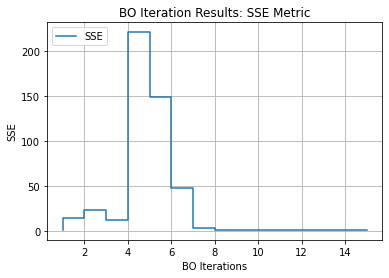

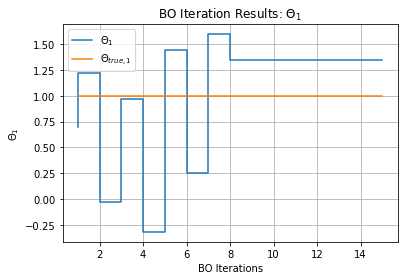

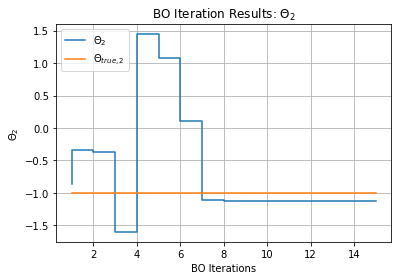

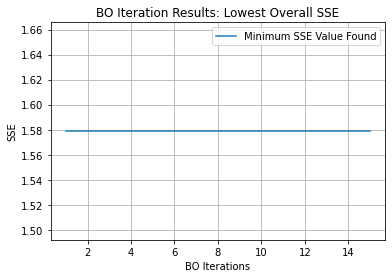

In [6]:
##Objective function = SSE
##USING SCIPY METHOD
##Uses 4 LHS Training points
shuffle_seed = 6
obj = "obj"
save_fig=False
restarts = 0

#Set 4 Point Training data, Model, and Likelihood
#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_sse = train_data[:,-1]
t = 4 #Just use last 4 points
train_T = train_T[0:t]
train_ln_sse = train_ln_sse[0:t]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_ln_sse,p,q,m,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, 
                          Yexp, obj, restarts, verbose = verbose,save_fig=save_fig,emulator = emulator)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

Explore Bias: tensor(0.)
Magnitude of SSE given Theta_Opt =  [ 0.9915106  -1.09833372] is 3.0689e-01


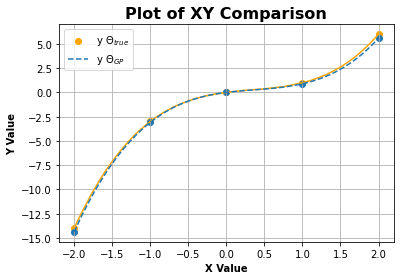

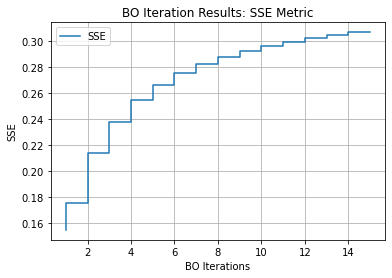

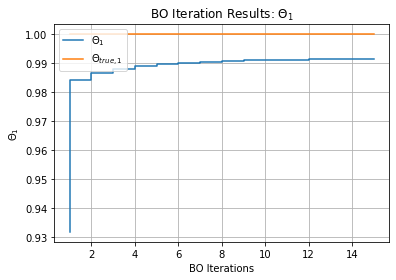

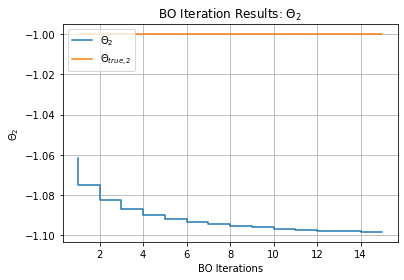

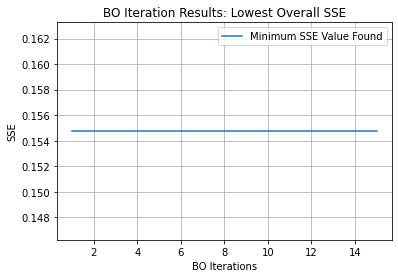

Explore Bias: tensor(0.1000)
Magnitude of SSE given Theta_Opt =  [ 0.99221736 -1.09850353] is 3.0795e-01


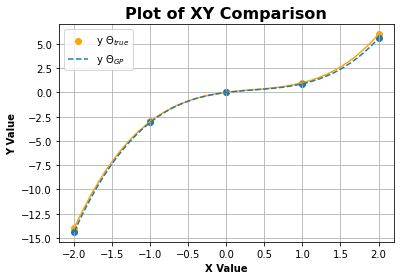

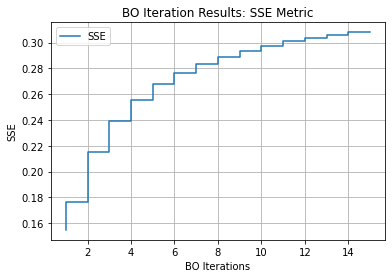

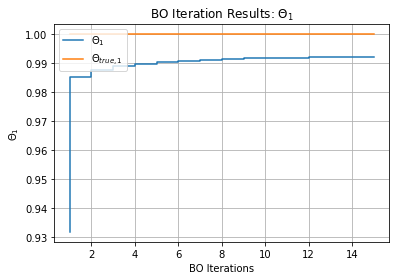

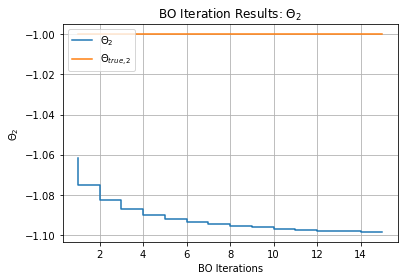

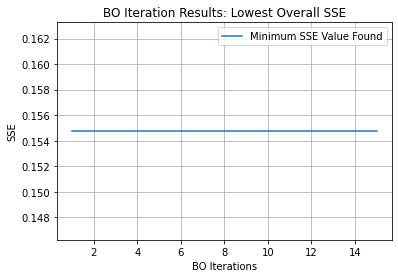

Explore Bias: tensor(0.5000)
Magnitude of SSE given Theta_Opt =  [ 0.99529335 -1.09939588] is 3.1374e-01


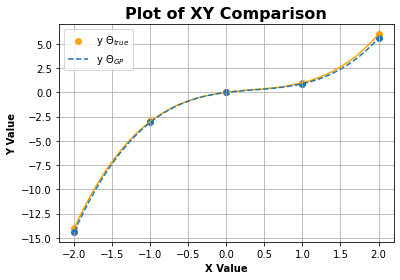

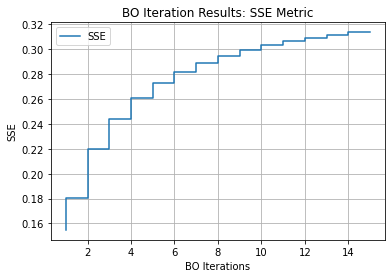

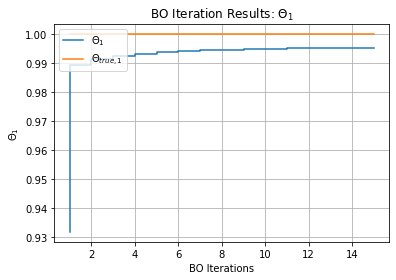

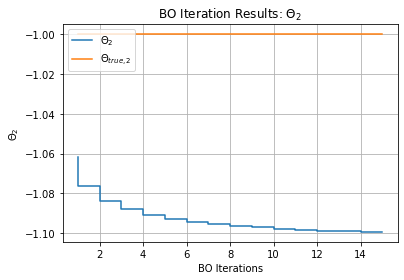

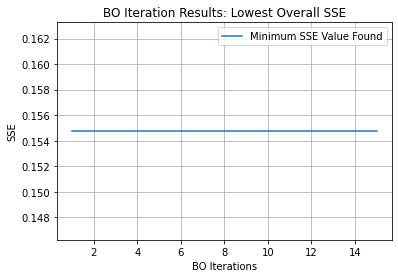

In [7]:
##Objective function = ln(SSE)
##USING SCIPY METHOD
##Uses 20 LHS points

save_fig=False
obj = "LN_obj"
restarts = 0

#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_ln_sse = train_data[:,-1]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_ln_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_ln_sse,p,q,m,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, 
                          Yexp, obj, restarts, verbose = verbose,save_fig=save_fig,emulator = emulator)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

Explore Bias: tensor(0.)
Magnitude of SSE given Theta_Opt =  [ 0.81202675 -0.93109464] is 5.0872e-01


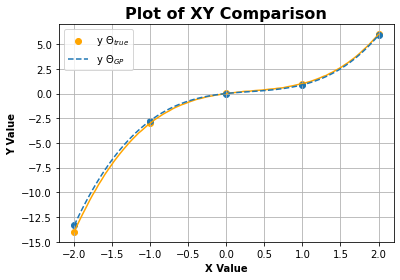

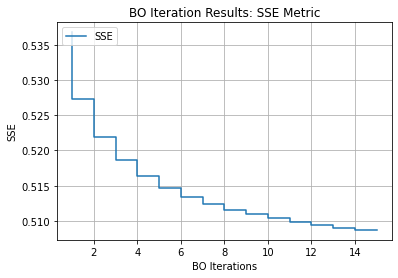

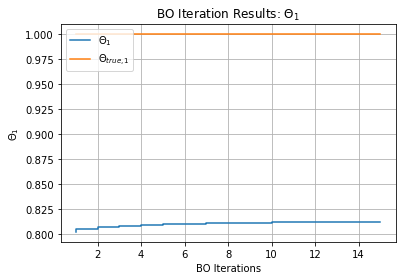

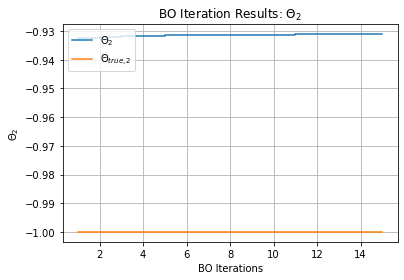

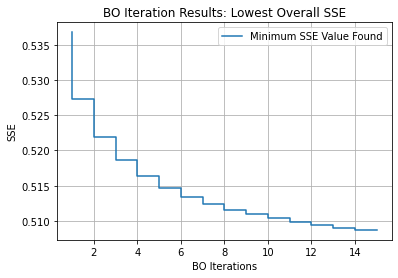

Explore Bias: tensor(0.1000)
Magnitude of SSE given Theta_Opt =  [ 0.81203868 -0.93109247] is 5.0869e-01


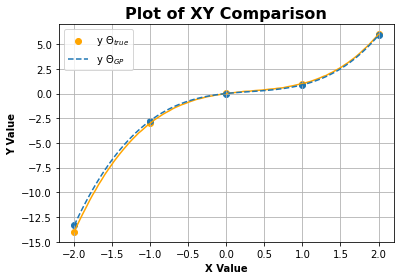

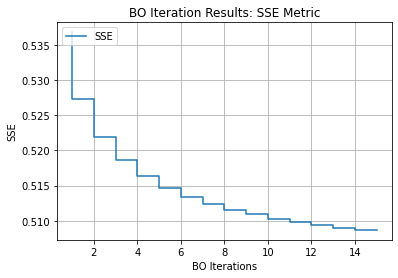

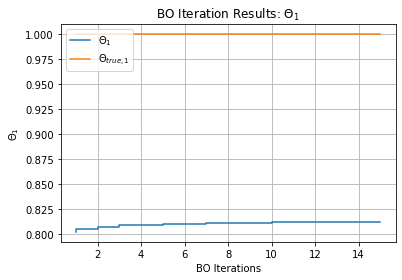

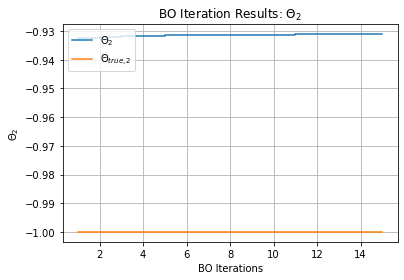

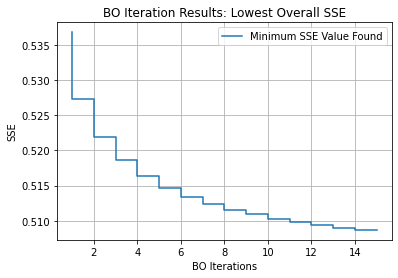

Explore Bias: tensor(0.5000)
Magnitude of SSE given Theta_Opt =  [ 0.81209259 -0.93108343] is 5.0854e-01


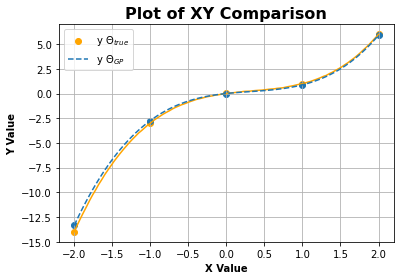

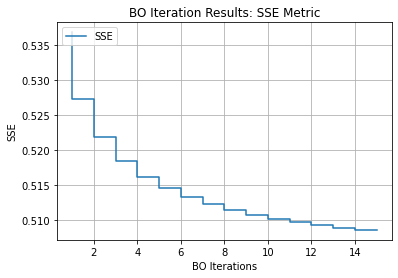

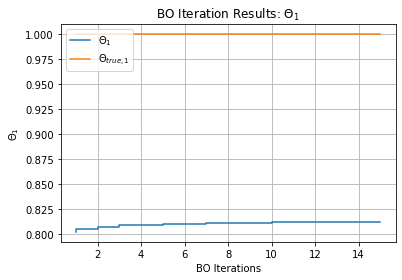

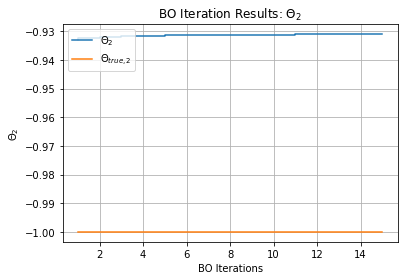

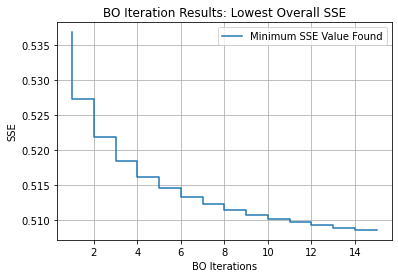

In [8]:
##Objective function = SSE
##USING SCIPY METHOD
##Uses 20 LHS Training points
save_fig=False
obj = "obj"
restarts = 0

#Set 20 Point Training data, Model, and Likelihood
#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_sse = train_data[:,-1]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_sse,p,q,m,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, 
                          Yexp, obj, restarts, verbose = verbose,save_fig=save_fig,emulator = emulator)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")